## Import Libraries

In [325]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

from fastapi import FastAPI


from sklearn import metrics

%matplotlib inline

In [327]:


import pandas
import numpy
import matplotlib
import seaborn
import sklearn

# Dictionary to store the libraries and their versions


print("FastAPI version:", pandas.__version__)
print("Pydantic version:", numpy.__version__)
print("Joblib version:", matplotlib.__version__)
print("Scikit-learn version:", seaborn.__version__)
print("NumPy version:", sklearn.__version__)


FastAPI version: 2.1.4
Pydantic version: 1.26.4
Joblib version: 3.7.5
Scikit-learn version: 0.13.2
NumPy version: 1.4.2


In [ ]:
FastAPI== 2.1.4
Pydantic==1.26.4
Joblib==3.7.5
Scikit-learn==0.13.2
NumPy==1.4.2


## Load the Data

In [281]:
#clean7 is the dataset after EDA 
df = pd.read_csv("clean7")

In [282]:
df.shape

(8588, 22)

In [283]:
df.head(2)

,Unnamed: 0,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,5,Manchester United,Harry Maguire,Defender Centre-Back,194.0,30.0,68,0.037799,0.000000,0.302394,...,0.0,0.0,4762,148,27,1,25000000,70000000,2,0
1,6,Manchester United,Victor Lindelöf,Defender Centre-Back,187.0,28.0,70,0.000000,0.032901,0.115153,...,0.0,0.0,5471,95,19,10,15000000,35000000,2,0


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [284]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,Unnamed: 0,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger


In [285]:
# Completeness
df.isnull().sum()

Unnamed: 0             0
team                   0
name                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
position_encoded       0
winger                 0
dtype: int64

In [286]:
# Accurecy types
df.dtypes

Unnamed: 0               int64
team                    object
name                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
position_encoded         int64
winger                   int64
dtype: object

In [287]:
#drop the unneeded col
df = df.drop(['Unnamed: 0'], axis=1)
df = df.drop(['name'], axis=1)


In [288]:

# put  categorical features in one list and numeric features on the other list
categorical_features = ['team', 'position', 'position_encoded', 'winger']
numeric_features = ['height', 'age', 'appearance','goals','assists','yellow cards','second yellow cards','red cards','goals conceded','clean sheets', 'minutes played', 'days_injured', 
                    'games_injured', 'award', 'highest_value']

In [289]:
for i in categorical_features:
    print (df[i].value_counts())

team
Daejeon Hana Citizen      42
Jeonbuk Hyundai Motors    40
FC Seoul                  39
Gangwon FC                37
Swallows FC               36
                          ..
Bayern Munich              7
FC Barcelona               7
Manchester City            7
Real Madrid                6
Gaziantep FK               5
Name: count, Length: 374, dtype: int64
position
Defender Centre-Back          1602
Attack Centre-Forward         1175
midfield-CentralMidfield      1011
midfield-DefensiveMidfield     804
Defender Right-Back            786
Defender Left-Back             737
midfield-AttackingMidfield     665
Attack-RightWinger             633
Attack-LeftWinger              614
Goalkeeper                     184
midfield-RightMidfield          94
midfield-LeftMidfield           92
midfield                        64
Attack-SecondStriker            53
Attack                          43
Defender                        31
Name: count, dtype: int64
position_encoded
2    3156
3    2730
4    

In [290]:
# Calculate the frequency of each 'position'
position_counts = df['position'].value_counts()

# Filter 'position' values that appear 10 or more times
df = df[df['position'].isin(position_counts[position_counts >= 2].index)]

In [291]:
# Calculate the frequency of each 'team'
team_counts = df['team'].value_counts()

# Filter 'team' values that appear 10 or more times
df = df[df['team'].isin(team_counts[team_counts >=2].index)]

In [292]:
df.shape

(8588, 20)

In [293]:
# Calculate the frequency of each 'winger'

winger_counts = df['winger'].value_counts()

# Filter 'winger' values that appear 10 or more times
df = df[df['winger'].isin(winger_counts[winger_counts >=2].index)]


In [294]:
df.shape

(8588, 20)

In [295]:
make_counts = df['position_encoded'].value_counts()

# Filter 'position_encoded' values that appear 10 or more times
df = df[df['position_encoded'].isin(make_counts[make_counts >=2].index)]
# position_encoded

In [296]:
df.shape

(8588, 20)

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [297]:
df.head(2)

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,Manchester United,Defender Centre-Back,194.0,30.0,68,0.037799,0.000000,0.302394,0.0189,0.0,0.0,0.0,4762,148,27,1,25000000,70000000,2,0
1,Manchester United,Defender Centre-Back,187.0,28.0,70,0.000000,0.032901,0.115153,0.0000,0.0,0.0,0.0,5471,95,19,10,15000000,35000000,2,0


#### 3. Feature selection

In [298]:
df = df[['yellow cards','red cards', 'position_encoded']]

In [299]:
df.head(2)

,yellow cards,red cards,position_encoded
0,0.302394,0.0,2
1,0.115153,0.0,2


#### 4. Prepare train and test data

In [300]:
# Prepare data
X = df


# sacle the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [301]:
X.shape

(8588, 3)

## Buliding the Model

In [302]:
# 2. Use NearestNeighbors to find the optimal eps
min_samples = 4

In [303]:
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_scaled)
distances, indices = nn.kneighbors(X_scaled)

In [304]:
#indices

In [305]:
distances[:,min_samples-1]

array([8.26025992e-04, 1.84276038e-03, 2.08714331e-03, ...,
       0.00000000e+00, 8.73673362e-01, 2.01265170e-03])

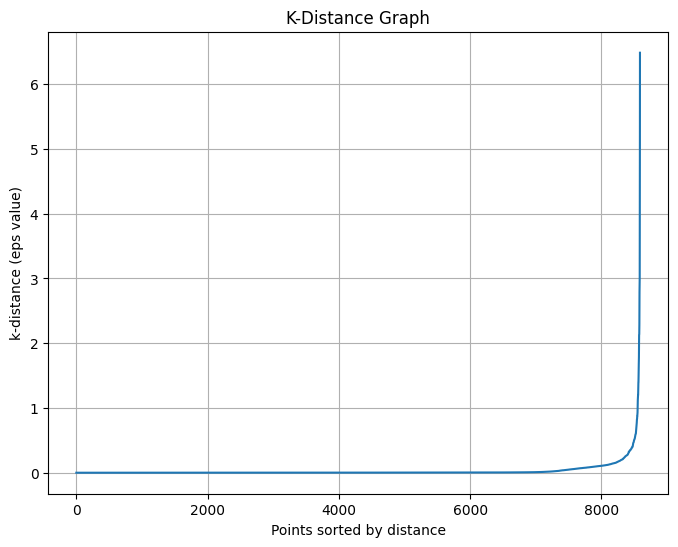

In [306]:
# The distance to the furthest neighbor (min_samples-th nearest) for each point
k_dist = distances[:, min_samples-1]

# Sort distances
k_dist_sorted = np.sort(k_dist)

# 3. Plotting the k-distance graph
plt.figure(figsize=(8, 6))
plt.plot(k_dist_sorted)
plt.title('K-Distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance (eps value)')
plt.grid(True)
plt.show()

In [307]:
# 4. Apply DBSCAN with chosen eps and min_samples
# Typically, you choose eps at the "elbow" point in this plot, where the slope changes significantly
chosen_eps = 0.3 # This is an example; choose this value based on the plot
dbscan = DBSCAN(eps=chosen_eps, min_samples=min_samples)

## Train the Model

In [308]:
# Fit the model on the training data

clusters = dbscan.fit_predict(X_scaled)

In [309]:
pd.Series(clusters).value_counts()

 0     2606
 2     2384
 4     2260
 1      462
 5      263
 3      201
 6      179
-1      153
 7       16
 9       14
 16       8
 10       7
 14       6
 11       5
 8        5
 12       5
 13       5
 15       5
 17       4
Name: count, dtype: int64

## Evaluating the Model 

In [310]:
silhouette_avg = silhouette_score(X, clusters)
silhouette_avg

-0.23749813913719117

In [311]:
X.head(2)

,yellow cards,red cards,position_encoded
0,0.302394,0.0,2
1,0.115153,0.0,2


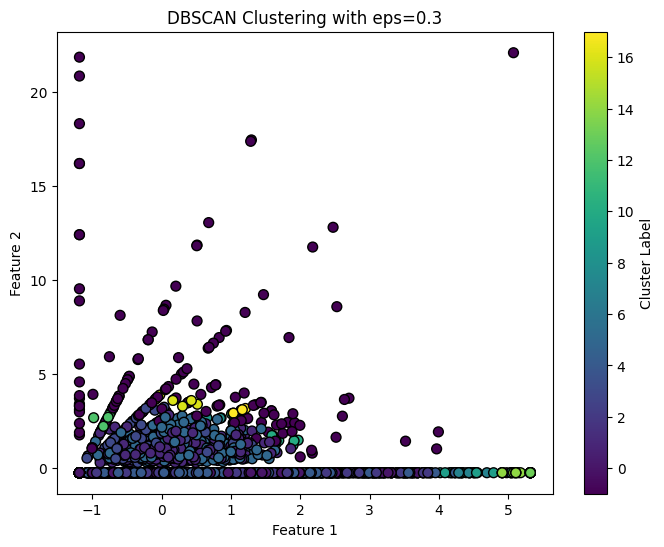

In [312]:
# 5. Plot the clustering result
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', s=50, edgecolor='k')
plt.title(f'DBSCAN Clustering with eps={chosen_eps}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [313]:
X['dbscan'] = clusters

In [314]:
X['dbscan'].value_counts()

dbscan
 0     2606
 2     2384
 4     2260
 1      462
 5      263
 3      201
 6      179
-1      153
 7       16
 9       14
 16       8
 10       7
 14       6
 11       5
 8        5
 12       5
 13       5
 15       5
 17       4
Name: count, dtype: int64

<Axes: xlabel='yellow cards', ylabel='red cards'>

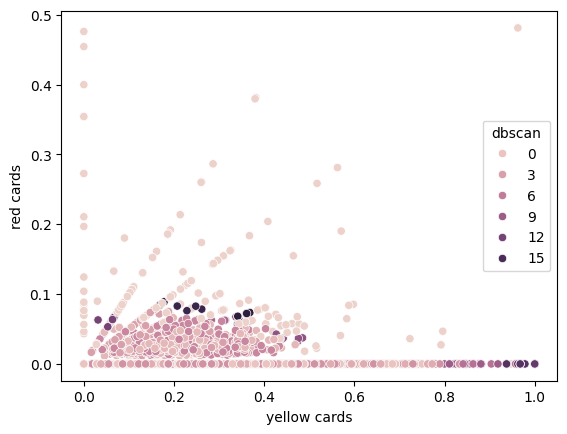

In [315]:
sns.scatterplot(data = X , x = 'yellow cards', y = 'red cards', hue = 'dbscan')


<Axes: xlabel='yellow cards', ylabel='position_encoded'>

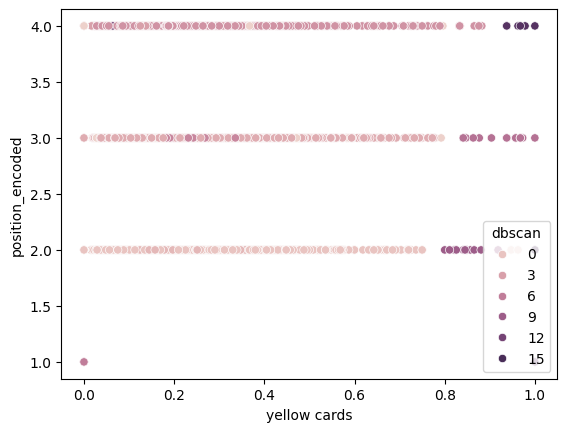

In [316]:
sns.scatterplot(data = X , x = 'yellow cards', y = 'position_encoded', hue = 'dbscan')

In [323]:
import joblib


# Assume you have already defined and trained your model
model1 = DBSCAN(eps=0.3, min_samples=4)

# Assume you have a trained scaler
scaler = StandardScaler()

# Save the model and scaler using joblib
joblib.dump(model1, 'DBSCAN_model1.joblib')
joblib.dump(scaler, 'scaler1.joblib')

['scaler1.joblib']

In [329]:
import joblib
model = joblib.load('DBSCAN_model1.joblib')
scaler = joblib.load('scaler1.joblib')



In [330]:
model.fit_predict([[0.1,0.1,1]])

  File "c:\Users\abuda\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


array([-1], dtype=int64)

In [319]:
import pickle

# Assuming 'clusters' is the object you want to save
# Save the 'clusters' object to a file named 'model.pkl' using pickle
# pickle.dump(model1, open('model3.pkl', 'wb'))

# print("Model saved successfully!")


In [320]:

# Load the model
model1=pickle.load(open('model3.pkl','rb'))
model1


DBSCAN(eps=0.3, min_samples=4)

In [321]:
import pickle

# Load the model

# Input data for prediction
input_data = [[1, 1, 1]]  # Assuming this is the format your model expects

# Make predictions using the loaded model
predictions = model1.fit_predict(input_data)

print(predictions)

[-1]


In [322]:
 fastapi  FastAPI, HTTPException
 pickle
 pydantic  BaseModel
 fastapi  FastAPI
 uvicorn
 joblib
 streamlit 
st.write("hello")

SyntaxError: invalid syntax (2312823692.py, line 1)

In [ ]:
pickle
pydantic  
fastapi  
uvicorn
joblib
streamlit